# Домашнее задание

С помощью CNN решить задачу множественной классификации изображений, в качестве данных использовать датасет CIFAR-10. Добиться точности классификации на тестовой выборке не менее 80% (для полного балла за ДЗ). Провести анализ ошибок - вычислить и построить гистограммы precision и recall для каждого класса, построить графики зависимости ошибок и точности тестовой и обучающей выборок в зависимости от эпох обучения.

**В ДЗ можно пользоваться кодом из лекции**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary
from collections import defaultdict
from IPython.display import clear_output


%matplotlib inline

device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda:0


1) **Загрузите датасет и разбейте его на train и test**

In [ ]:
# загружаем тренировочный датасет CIFAR10
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Обратите внимание что теперь 10 уникальных классов (не 2 как в лекции)
print(np.unique(dataset.targets))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
#Размер всего датасета
print(dataset.data.shape)

(50000, 32, 32, 3)


In [ ]:
#Делим датасет на тренировочную и тестовую части
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)


In [ ]:
batch_size = 64
hidden_sizes = [128, 256, 256]
batch_size = 64
input_size = 32 * 32
num_classes = 10
lr = 0.001
num_epochs = 50

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
train_batch_gen = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
for item, label in train_batch_gen:
  print(item.shape, label.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(), 
    transforms.ToTensor()
])

2) **Обучите сеть**

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model.forward(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

3) **Cоздайте класс сети**

In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
      super().__init__()

      model = nn.Sequential()
      # Блок 1: Свёртка с большим ядром, чтобы уловить общие закономерности
      model.add_module(
          'conv1', 
          nn.Conv2d(
              3, 16, 
              kernel_size=5,  
              padding=2
          )
      )
      # Важно! Батч-нормализация всегда идёт до функции активации!
      model.add_module('bn1', nn.BatchNorm2d(16))
      model.add_module('mp1', nn.MaxPool2d(2))
      model.add_module('relu1', nn.ReLU())
      model.add_module('dp1', nn.Dropout(0.2))

      # Блок 2: Свёртка с ядром поменьше, выделяет более тонкие признаки.
      model.add_module('conv2', nn.Conv2d(16, 32, kernel_size=3, padding=1))
      model.add_module('bn2', nn.BatchNorm2d(32))
      model.add_module('mp2', nn.MaxPool2d(2))
      model.add_module('relu2', nn.ReLU())
      # Важно! Дропаут идёт после функции активации!
      model.add_module('dp2', nn.Dropout(0.2))

      # Блок 3: Линейный слой поверх карт активации
      model.add_module('flatten', nn.Flatten())
      model.add_module('fc1', nn.Linear(2048, 512))
      model.add_module('bn3', nn.BatchNorm1d(512))
      model.add_module('relu3', nn.ReLU())
      model.add_module('dp3', nn.Dropout(0.2))

      # Блок 4: Классификационный слой
      model.add_module('fc2', nn.Linear(512, 10))
      self.model = model

  def forward(self, x):
      return self.model(x)
  # your code here
  # Hint: возможно стоит попробовать готовые и даже уже предобученные сети (наподобие VGG с лекции)
  # Hint: если вы хотите написать свою сеть, используйте те же слои, которые мы разбирали на лекции (следите за порядком слоев!)

In [ ]:
fmodel = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)



4) **Построите графики обучения и проанализируйте ошибки сети, сделайте выводы**

Epoch 60 of 60 took 26.805s
  training loss (in-iteration): 	0.880730
  validation loss (in-iteration): 	0.941383
  training accuracy: 			69.25 %
  validation accuracy: 			67.69 %


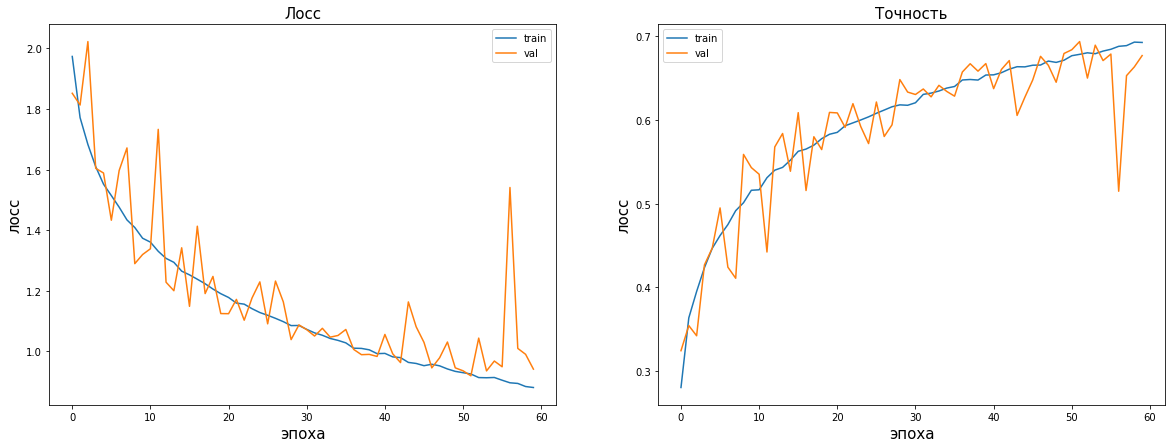

In [ ]:
# your code here
model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=60
)
# Hint: графики необходимы для того, чтобы следить за тем, не переобучилась ли модель
# в случае переобучения можно попробовать изменить размер сети, добавить слои batchnorm и dropout

In [ ]:
# Тестирование
pred_vec = []
correct = 0
model.eval()
with torch.no_grad():
    for data in test_batch_gen:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the test images: %.2f %%' % (100 * correct / len(test_dataset)))

Accuracy on the test images: 73.06 %


In [ ]:
class MyCNN2(nn.Module):
  def __init__(self):
    super(MyCNN2, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
    self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn_conv1 = nn.BatchNorm2d(128)
    self.bn_conv2 = nn.BatchNorm2d(128)
    self.bn_conv3 = nn.BatchNorm2d(256)
    self.bn_conv4 = nn.BatchNorm2d(256)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 256 * 8 * 8)
    out = self.dense_layers(out)
    return out

Epoch 60 of 60 took 48.007s
  training loss (in-iteration): 	0.382616
  validation loss (in-iteration): 	0.666351
  training accuracy: 			86.54 %
  validation accuracy: 			79.12 %


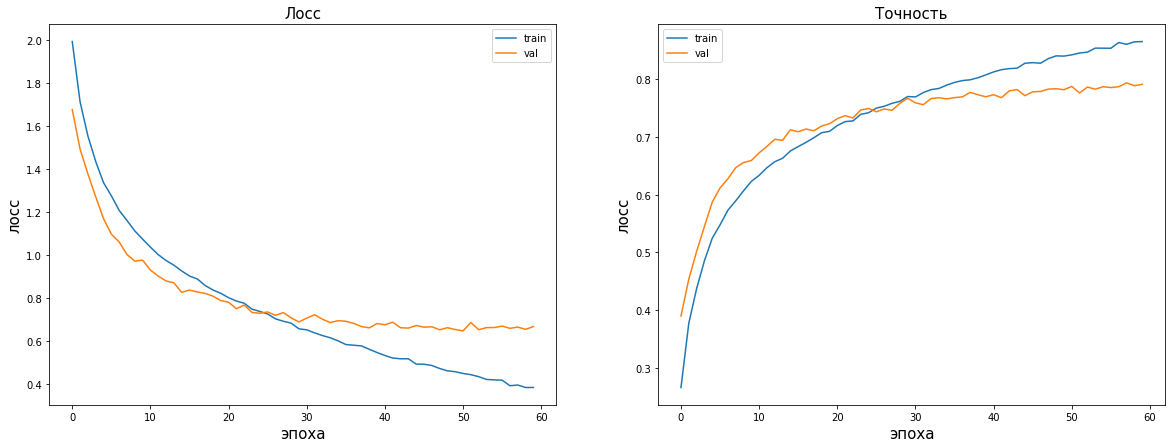

In [ ]:
model = MyCNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=60
)

In [ ]:
# Тестирование
pred_vec = []
correct = 0
model.eval()
with torch.no_grad():
    for data in test_batch_gen:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the test images: %.2f %%' % (100 * correct / len(test_dataset)))

Accuracy on the test images: 82.41 %


In [ ]:
# набор аугментаций при обучении
transform_train = transforms.Compose([
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

# набор аугментаций при валидации
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Загружаем данные с аугментациями:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Инициализируем даталоадеры:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

Epoch 60 of 60 took 25.117s
  training loss (in-iteration): 	0.865719
  validation loss (in-iteration): 	0.916002
  training accuracy: 			69.59 %
  validation accuracy: 			68.95 %


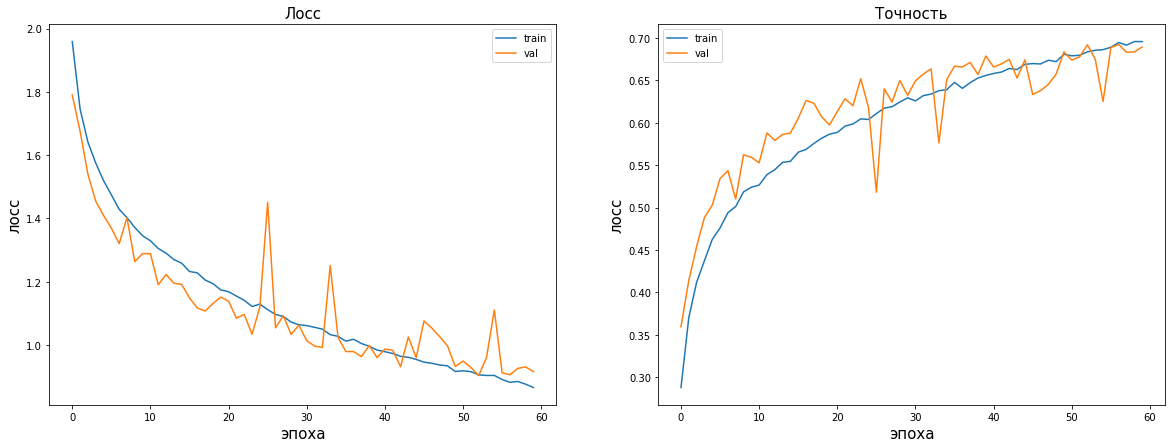

In [ ]:
# Обучим нейросеть на новых данных:
model =  MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=60
)

In [ ]:
# Тестирование
pred_vec = []
correct = 0
model.eval()
with torch.no_grad():
    for data in test_batch_gen:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the test images: %.2f %%' % (100 * correct / len(test_dataset)))

Accuracy on the test images: 74.66 %
